In [4]:
%pylab inline
data_dir = './output/'
filename = data_dir + 'img_rgood.jpg'

Populating the interactive namespace from numpy and matplotlib


- step 1, mbd saliency detection

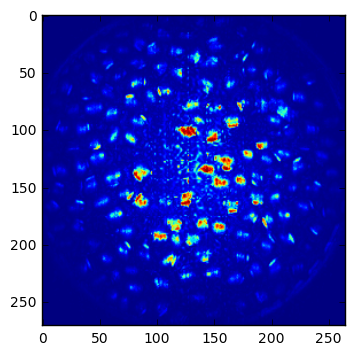

In [5]:
import pyimgsaliency as psal
import cv2

mbd = psal.get_saliency_mbd(filename)
imshow(mbd)

In [6]:
from utils import mark_foreground, mark_background

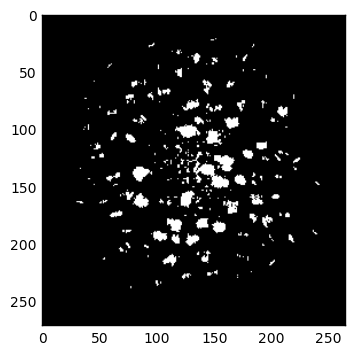

In [7]:
fg = mark_foreground(mbd, 0.05)
imshow(fg, cmap='gray')

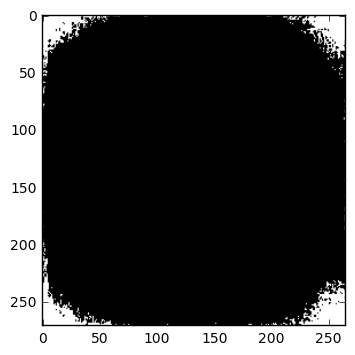

In [46]:
bg = mark_background(mbd, 0.05) #paper里说的是0.05; 而图其实是0.2的图，所以paper的图应该需要更正。
imshow(bg, cmap='gray')

- 获得foreground和background的spectral

In [47]:
from utils import readBeanData
rgood = readBeanData('./data/red_good.txt')

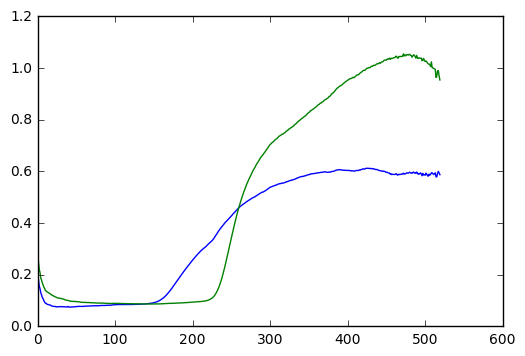

In [48]:
fg_spectral = np.average(rgood[fg,:], axis=0)
bg_spectral = np.average(rgood[bg,:], axis=0)
hold
plot(fg_spectral)
plot(bg_spectral)

- step 2: slic superpixel

In [49]:
from utils import makeRGB
img_rgood = makeRGB(rgood)

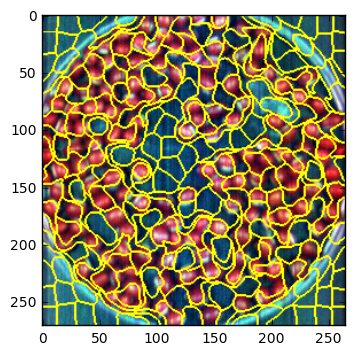

In [50]:
from skimage.segmentation import slic, mark_boundaries
segments = slic(img_rgood, n_segments=300, sigma=5)
out=mark_boundaries(img_rgood,segments)
imshow(out)

- mark superpixels to be forground or background

In [63]:
import numpy as np
from numpy.linalg.linalg import norm
def get_samples(data, segments, fg_spectral, bg_spectral):
    maxIter = np.max(segments)
    samples = []
    for i in range(0, maxIter):
        region = (segments==i)
        sample = np.average(data[region], axis=0)
        dis_fg = norm(sample/norm(sample)-fg_spectral/norm(fg_spectral)) # 归一化之后再比较距离
        dis_bg = norm(sample/norm(sample)-bg_spectral/norm(bg_spectral)) # 归一化之后再比较距离
        if(dis_fg<=dis_bg):
            samples.append(sample)
    return samples
s = get_samples(rgood, segments, fg_spectral, bg_spectral)
np.stack(s).shape

(146, 520)

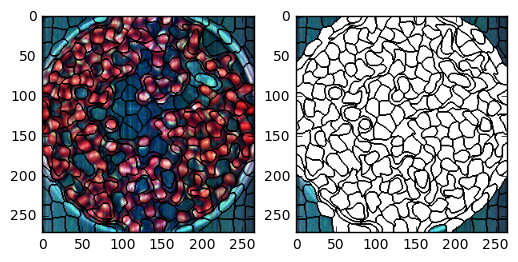

In [72]:
from skimage.segmentation import mark_boundaries
import numpy as np
from numpy.linalg.linalg import norm
def mark_samples(data, img, segments, fg_spectral, bg_spectral):
    img_result = mark_boundaries(img, segments, color=(0,0,0))
    result = np.copy(img_result)
    maxIter = np.max(segments)
    for i in range(0, maxIter):
        region = (segments==i)
        sample = np.average(data[region], axis=0)
        dis_fg = norm(sample-fg_spectral)
        dis_bg = norm(sample-bg_spectral)
        #print(dis_fg, dis_bg)
        if(dis_fg<=dis_bg):
            result[region, :] = 1
    
    result = mark_boundaries(result, segments, color=(0,0,0))
    return img_result, result

img, mark = mark_samples(rgood, img_rgood, segments, fg_spectral, bg_spectral)

subplot(1,2,1)
imshow(img)
subplot(1,2,2)
imshow(mark)

# 生成所有样本

In [73]:
data_dir = './data/'
fname_beans = {
    'ggood': data_dir + 'green_good.txt',
    'gspoiled': data_dir + 'green_spoil.txt',
    'gswollen': data_dir + 'green_water.txt',
    'gstale': data_dir + 'green_old.txt',
    'rgood': data_dir + 'red_good.txt',
    'rspoiled': data_dir + 'red_spoil.txt',
    'rswollen': data_dir + 'red_water.txt',
    'rstale': data_dir + 'red_spoil.txt'
}

In [70]:
tmpfile = './output/tmp.jpg'
import pickle
def genSamples(tbl):
    for k,v in tbl.items():
        print(k,v)
        data = readBeanData(v)
        data_img = makeRGB(data)
        imsave(tmpfile, data_img)
        data_mbd = psal.get_saliency_mbd(tmpfile)
        fg = mark_foreground(data_mbd)
        bg = mark_background(data_mbd)
        fg_spectral = np.average(data[fg,:], axis=0)
        bg_spectral = np.average(data[bg,:], axis=0)
        segments = slic(data_img, n_segments=300, sigma=5)
        samples = get_samples(data, segments, fg_spectral, bg_spectral)
        print(len(samples))
        with open('./output/'+k+'.pkl', 'wb') as f:
            pickle.dump(samples, f)

In [71]:
genSamples(fname_beans)

rswollen ./data/red_water.txt
92
gspoiled ./data/green_spoil.txt
102
gstale ./data/green_old.txt
99
rgood ./data/red_good.txt
146
rspoiled ./data/red_spoil.txt
132
gswollen ./data/green_water.txt
70
ggood ./data/green_good.txt
99
rstale ./data/red_spoil.txt
132
